### OR 610: Deep Learning. Spring 2023

# HW 1 - Neural Networks, backpropagation, and introduction to PyTorch

Credit: Artem Babchenko (https://github.com/aosokin/dl_cshse_ami/tree/master/2019-spring/seminars/seminar1)

## Organic Neural Network
In this section, you will need to independently implement a neural network and train it using the backpropagation method.


In [1]:
import numpy as np

In [2]:
# First, we define a base class, Layer, with the main methods .forward () and .backward ().
# This is an identify layer that returns whatever it gets as input. Use it as an example for the hw questions

class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # An identity layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # An identity layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of an identity layer is precisely grad_output
        input_dim = input.shape[1]
        
        d_layer_d_input = np.eye(input_dim)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule
    
    

### Next Steps

Now, you need to build a neural network to classify handwritten numbers. To do this, you need to implement the following:
- ReLU layer
- Fully connected layer, $ f (x) = Wx + b $
- Loss function, for the classification problem - cross-entropy
- Backpropagation algorithm

Next, you will need to implement each of the points above using the provided code snippets.

### ReLU layer
This layer uses the element-wise nonlinearity $ f (X) = max (X, 0) $. In this layer, you only need to implement the .forward () method.

In [8]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        # TODO: <your code>
        output = np.maximum(0,input)
        return output
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad_mask = input > 0
        return grad_output * relu_grad_mask        

To debug the gradients calculated analytically, it is recommended to use the comparison with the gradients calculated numerically. If you have implemented the .forward () and .backward () methods correctly, the gradient values will be close enough. The function for numerical calculation of gradients is already implemented in the util.py file

In [9]:
# some tests
from hw1_util import eval_numerical_gradient
points = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(points, np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=points)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

### Fully connected layer
A fully connected layer has trainable parameters: a linear transformation matrix and a column of bias parameters.

$$ f (X) = W X + b $$

* X - matrix of input data of size [batch_size, num_features],
* W - size transformation matrix [num_features, num_outputs]
* b - column of free members of size [num_outputs]

W and b need to be initialized at layer creation time and updated every time the .backward () method is called.
For this layer you need to implement both forward and backward pass.

In [35]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers from normal distribution
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        #TODO: <your code here>
        W = self.weights
        X = input
        b = self.biases
        
        Wx = np.matmul(X, W)
        
        return (Wx + b)
    
    def backward(self,input,grad_output):
        
        #TODO: 
        # compute d loss / d x = d loss / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        W = self.weights
        grad_input = np.dot(grad_output,W.T)
        
        #TODO: 
        # compute gradient of loss w.r.t. weights and biases
        grad_weights = (np.dot(grad_output.T,input)).T
        grad_biases = np.sum(grad_output, axis = 0)
        
        
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input
    
'''
References: 

1. Coding a Neural Network with Numpy
https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795

'''

'\nReferences: \n\n1. Coding a Neural Network with Numpy\nhttps://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795\n\n'

### Testing a fully connected layer

The next three blocks test your implementation, if everything is correct, you will get "Well done!"

In [36]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


In [37]:
# To test the grads, we use gradients obtained via finite differences

from hw1_util import eval_numerical_gradient

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [38]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases
    
w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


### Loss function

Calculation of the loss function for the classification problem, as well as its gradient, is already done for you.

In [39]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [40]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

### Final neural network

Everything is ready to train and use the neural network. We will test the neural network on the classic MNIST dataset. The code below renders several examples from this dataset.

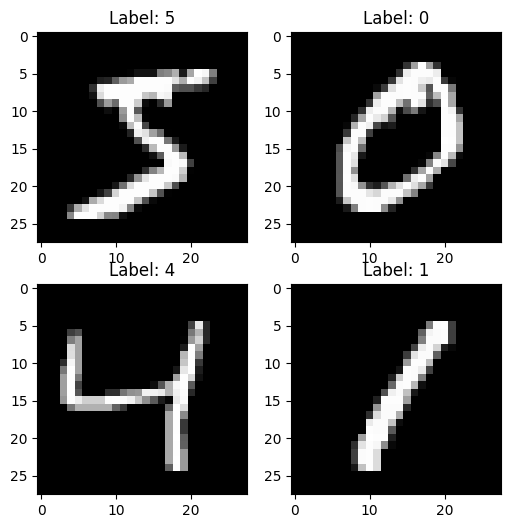

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

from hw1_util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In our implementaiton, the network is just a Python list that contain the layers as element

In [42]:
network = []
hidden_layers_size = 40
network.append(Dense(X_train.shape[1], hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, 10))

Implement a forward pass over the entire network by calling .forward () sequentially on each layer.

In [58]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X
    
    #TODO: <your code here>
    for i in range(len(network)):
        activations.append(network[i].forward(X))
        X = network[i].forward(X)
    
    assert len(activations) == len(network)
    return activations

#print(len(network))

def predict(network, X):
    """
    Use network to predict the most likely class for each sample.
    """
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)

In [95]:
def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X] + layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # TODO:  
    # propagate gradients through network layers using .backward
    # hint: start from last layer and move to earlier layers
    #<YOUR CODE>
    n = len(network)
    for i in range(1,n):
        loss_grad = network[n - i].backward(layer_activations[n - i - 1], loss_grad)
        
    return np.mean(loss)

Everything is ready to start training. If everything is implemented correctly, then the classification accuracy on the validation set should exceed 97%.

In [96]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

Epoch 14
Train accuracy: 0.79122
Val accuracy: 0.8045


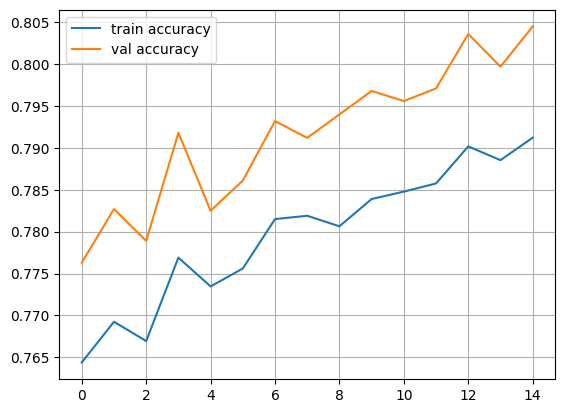

In [97]:
from IPython.display import clear_output
train_log = []
val_log = []

for epoch in range(15):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

## Introduction to PyTorch

### Installing PyTorch

#### Linux/Mac/Windows


On the PyTorch website http://pytorch.org/, you need to select the appropriate configuration and install the PyTorch packages and the corresponding torchvision.

The python version can be found in the terminal:
```
python --version
```

In [3]:
import torch
import numpy as np

/Users/syedhadi/Library/Python/3.10/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [99]:
# numpy world

x = np.arange(16).reshape(4, 4)

print("X :\n %s" % x)
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n", np.dot(x, x.T))
print("mean over cols :\n%s" % (x.mean(axis=-1)))
print("cumsum of cols :\n%s" % (np.cumsum(x, axis=0)))

X :
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
add 5 :
[[ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]
 [17 18 19 20]]
X*X^T  :
 [[ 14  38  62  86]
 [ 38 126 214 302]
 [ 62 214 366 518]
 [ 86 302 518 734]]
mean over cols :
[ 1.5  5.5  9.5 13.5]
cumsum of cols :
[[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]
 [24 28 32 36]]


In [100]:
# pytorch world

x = np.arange(16).reshape(4, 4)

x = torch.from_numpy(x).type(torch.FloatTensor) #or torch.arange(0,16).view(4,4)

print("X :\n%s" % x)
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n", torch.matmul(x, x.transpose(1, 0)))
print("mean over cols :\n", torch.mean(x, dim=-1))
print("cumsum of cols :\n", torch.cumsum(x, dim=0))

X :
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
add 5 :
tensor([[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]])
X*X^T  :
 tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])
mean over cols :
 tensor([ 1.5000,  5.5000,  9.5000, 13.5000])
cumsum of cols :
 tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


### NumPy vs Pytorch

Numpy and Pytorch do not use a static computational graph (like TensotFlow). 

You can debug your code uising pdb or simply print. A huge advantage!

API is slightly different:

```
x.reshape([1,2,8]) -> x.view(1,2,8)
x.sum(axis=-1) -> x.sum(dim=-1)
x.astype('int64') -> x.type(torch.int64)
```


Easy to convert:

```
torch.from_numpy(npx) -- returns Tensor
tt.numpy() -- returns Numpy Array
```

A 1x1 tensor can be converted to a Python numeric (a number):
```
torch.tensor([1]).item() -> 1
```


For help:
- Documentation https://pytorch.org/docs/
- Google (Stackoverflow/tutorials)

In [119]:
x = torch.linspace(0, 2 * np.pi, 16, dtype=torch.float64)

#TODO: Mini-task: compute a vector of sin^2(x) + cos^2(x) using PyTorch
out = (torch.sin(x)**2) + torch.cos(x)**2

print(out.numpy())

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Automatic gradients

Every tensor in Pytorch has a `requires_grad` flag, which is responsible for the automatic computation of gradients:

1. Create a variable: `a = torch.tensor (..., requires_grad = True)`

2. Define some differentiable function `loss = whatever (a)`

3. Run a backward pass `loss.backward ()`

4. Gradients will be available in `a.grads`


There are two important differences between Pytorch and Theano / TF:

1. The error function can be changed dynamically, for example, at each minibatch.

2. After calculating `.backward ()`, the gradients are stored in `.grad` for each involved variable, and on repeated calls the gradients are summed. This allows multiple error functions to be used or virtually increase batch_size. Therefore, after each step of the optimizer, the gradients should be zeroed.


### Leaf vs Non-leaf Variable:
```
x = torch.tensor([1., 2., 3., 4.], requires_grad=True))  # leaf tensor
y = x + 1  # not a leaf variable
```
The gradients will be saved and available for use only for the leaf tensor.
This behavior is done by default to save memory. All tensors with the `requires_grad = False` flag are considered` leaf tensors` by default.


Note that the calculation of gradients only works for tensors with real data types:

In [63]:
# will not work
x = torch.tensor([1, 2, 3, 4], requires_grad=True)

RuntimeError: Only Tensors of floating point and complex dtype can require gradients

To set the flag `requires_grad = False` and turn off automatic gradient computation for multiple tensors, you can use` with torch.no_grad () `or` detach`:

In [71]:
x = torch.tensor([1.], requires_grad=True)
y = x**2
print(x.requires_grad)
print(y.requires_grad)

with torch.no_grad():
    z = torch.exp(x)
    print(z.requires_grad)
    
# detach from the graph
w = torch.log(x).detach()
print(w.requires_grad)

True
True
False
False


Let's look at an example of linear regression on the Boston dataset

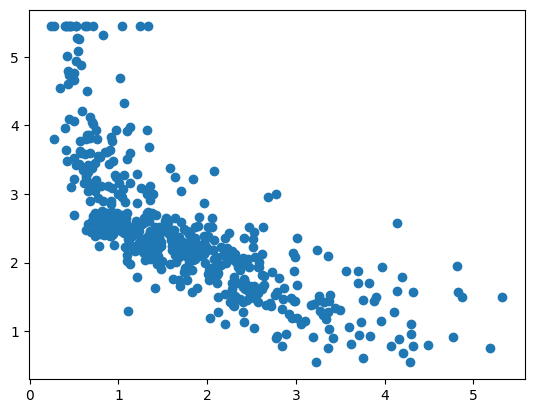

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston


#importing boston housing dataset from source since it has been removed from scikit-learn since version 1.2.
#import pandas as pd
#data_url = "http://lib.stat.cmu.edu/datasets/boston"
#raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
#X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
#y = raw_df.values[1::2, 2]


x, y = load_boston(return_X_y=True)



#select one column for simplicity. 
x = x[:, -1] / x[:, -1].std()
y = y / y.std()

plt.scatter(x, y)

In [73]:
# model tensors
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# data tensors
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# all tensors are leaf-tensors
# gradients of x and y won't be computed
for vv in [w, b, x, y]:
    print(vv.is_leaf, vv.requires_grad)

True True
True True
True False
True False


In [74]:
#try out gradients
y_pred = w * x + b
loss = torch.mean((y_pred - y)**2)

loss.backward()

#now w.grad is a tensor containing gradient of L w.r.t. w

print("dL/dw = \n", w.grad)
print("dL/db = \n", b.grad)

# no gradients for tensors with requires_grad=False
# and non-leaf tensors
print("Non-Leaf x dL/dx = \n", x.grad)
print("Non-Leaf loss dL/dpred = \n", y_pred.grad)

dL/dw = 
 tensor([-7.2240])
dL/db = 
 tensor([-4.9048])
Non-Leaf x dL/dx = 
 None
Non-Leaf loss dL/dpred = 
 None


/var/folders/v6/qqg59gxn3_97mp296vmspdpm0000gn/T/ipykernel_14284/3846789532.py:15: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:485.)
  print("Non-Leaf loss dL/dpred = \n", y_pred.grad)


### Gradients of intermediate nodes

In the graph we described, `x` and` y_pred` are not leaf nodes. By default, no gradients are saved for them.

For intermediate nodes, we can request that gradients be preserved using the `.retain_grad ()` function.

In [75]:
y_pred = w * x + b

# check this:
y_pred.retain_grad()

loss = torch.mean((y_pred - y)**2)
loss.backward()

print("Non-Leaf loss dL/dpred = \n", y_pred.grad[:10])

Non-Leaf loss dL/dpred = 
 tensor([-0.0103, -0.0093, -0.0149, -0.0144, -0.0156, -0.0123, -0.0099, -0.0117,
        -0.0071, -0.0081])


### Linear Regression

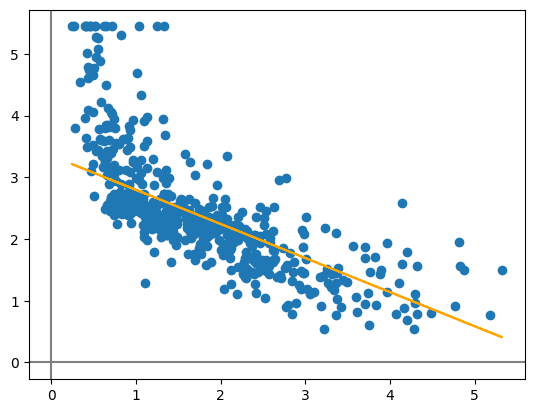

loss =  0.49713194370269775
Done!


In [76]:
from IPython.display import clear_output

for i in range(100):
    
    #compute loss
    y_pred = w * x  + b
    loss = torch.mean((y_pred - y)**2)
    
    # backprop
    loss.backward()
    
    # TODO: gradient descent step for weights
    # take alpha about 0.1
    with torch.no_grad():
        w -= (0.1 * w.grad)
        b -= (0.1 * b.grad)
    
    #zero gradients
    w.grad.zero_()
    b.grad.zero_()
    
    #the rest of code is just bells and whistles
    if (i + 1) % 5==0:
        #draw linear regression prediction vs data
        clear_output(True)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.scatter(x.numpy(),y.numpy())
        plt.plot(x.numpy(),y_pred.data.numpy(),color='orange')
        plt.show()

        print("loss = ", loss.item())
        if loss.item() < 0.5:
            print("Done!")
            break

### Optimizers

In this example, we have used a simple gradient descent rule:
  
$$\theta^{n+1} = \theta^{n} - \alpha \nabla_{\theta}L$$

The only parameter in it is $ \alpha $ - this is `learning_rate`.

In practice, various modifications are often used (for example, _Momentum_):

$$\theta^{n+1} = \theta^{n} - U^{n}\\
U^{n} = \gamma U^{n-1} + \alpha \nabla_{\theta}(L)
$$

A good overview of optimization algorithms for networks can be found [here] (http://ruder.io/optimizing-gradient-descent/).



Pytorch provides almost all common optimizers:
http://pytorch.org/docs/master/optim.html




Optimizers are easy to use:

- you need to specify a list of variables for optimization
- `opt.step ()` applies `update` ($ U ^ {n} $) to weights
- `opt.zero_grad ()` resets gradients

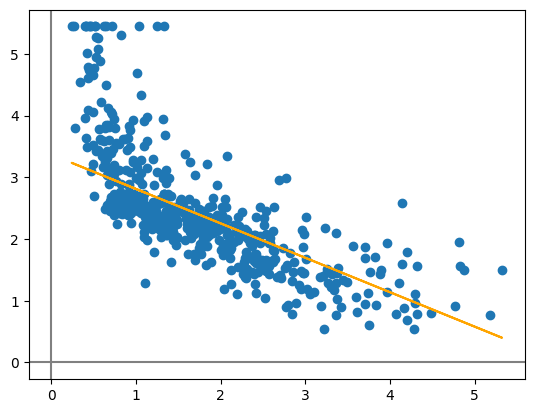

loss =  0.49351760745048523
Done!


In [77]:
# get data
x, y = load_boston(return_X_y=True)
x = x[:, -1] / x[:, -1].std()
y = y / y.std()

# data tensors
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# model tensors
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# define optimizer
opt = torch.optim.RMSprop([w, b], lr=0.1)

for i in range(100):
    # TODO: compute prediction and loss using linear regression
    y_pred = w * x  + b
    loss = torch.mean((y_pred - y)**2)
    
    # backprop and gradient descent
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    #the rest of code is just bells and whistles
    if (i + 1) % 5 == 0:
        #draw linear regression prediction vs data
        clear_output(True)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.scatter(x.numpy(), y.numpy())
        plt.plot(x.numpy(), y_pred.data.numpy(), color='orange')
        plt.show()

        print("loss = ", loss.item())
        if loss.item() < 0.5:
            print("Done!")
            break

### Highlevel-API 

When working with neural networks, it becomes inconvenient to control variables with weights separately. Pytorch provides a high level API for models http://pytorch.org/docs/master/nn.html#torch.nn.Module.


To use the model it is necessary to inherit from torch.nn.Module, define layers and describe `forward`,` backward` will be calculated automatically.


Let's use MNIST again for demonstration.

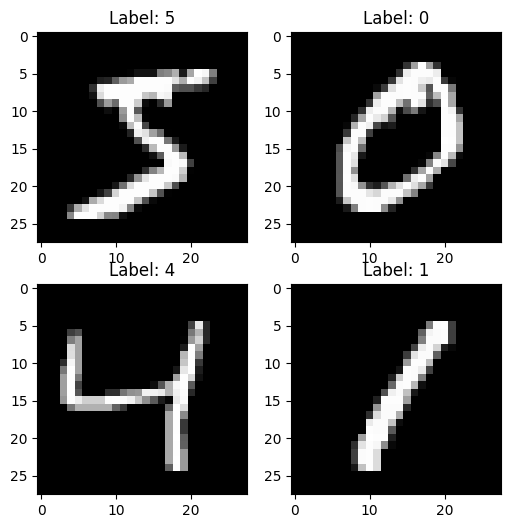

In [88]:
# MNIST again
from hw1_util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title("Label: %i" % y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]), cmap='gray');

In [89]:
# Higher-level API:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, hidden_size=40):
        super(Net, self).__init__()
        # here you construct weights for layers
        self.fc1 = nn.Linear(X_train.shape[1], hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)
        
    def forward(self, x):
        # here you describe usage of layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # check log_softmax signature
        return F.log_softmax(x, dim=-1)
    # backward function computes automaticaly

In [90]:
# model interface:
model = Net()
tt = torch.from_numpy(X_train[:10, :].astype(np.float32))
output = model(tt)

print('Model outputs: \n', output)
# TODO: calculate probabilities from the output using  torch functions
# hint: see log_softmax documentation
probs = torch.exp(output)
print('Probs: \n', probs)

# TODO: calculate prediction from output using torch function
pred = torch.argmax(probs, dim = 1)
print('Pred: \n', pred.data.numpy())
print('Truth: \n', y_train[:10])

Model outputs: 
 tensor([[-2.2272, -2.2592, -2.4394, -2.4956, -2.0819, -2.2166, -2.2185, -2.2872,
         -2.4193, -2.4637],
        [-2.2372, -2.2690, -2.4828, -2.5416, -2.0594, -2.1706, -2.2318, -2.3150,
         -2.4006, -2.4171],
        [-2.2203, -2.2507, -2.4523, -2.5280, -2.1288, -2.2086, -2.1791, -2.2744,
         -2.4145, -2.4541],
        [-2.2422, -2.2840, -2.4750, -2.5050, -2.0815, -2.1836, -2.1951, -2.3221,
         -2.3853, -2.4396],
        [-2.2230, -2.2680, -2.4551, -2.5195, -2.0884, -2.2060, -2.1853, -2.3225,
         -2.4059, -2.4401],
        [-2.2060, -2.2353, -2.4516, -2.4976, -2.1241, -2.2141, -2.2022, -2.3085,
         -2.4255, -2.4388],
        [-2.2303, -2.2340, -2.4575, -2.4691, -2.1148, -2.2179, -2.2210, -2.2991,
         -2.4115, -2.4411],
        [-2.2426, -2.2582, -2.4491, -2.5219, -2.0765, -2.1952, -2.1983, -2.2990,
         -2.4209, -2.4571],
        [-2.2379, -2.2248, -2.4723, -2.4630, -2.1096, -2.2153, -2.2172, -2.3088,
         -2.4140, -2.4361],
  

### Network training

To train the network, we need
- data iterator
- training function (run over data, calculate and apply gradients)
- validation function (run on test data, calculation of metrics)

In [178]:
from IPython.display import clear_output
from tqdm import trange

# function for iterating over minibatch, from the first assignment
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [193]:
def train(model, optimizer, batchsize=32):
    loss_log = []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # data preparation
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        # compute gradients
        loss.backward()
        # make a step
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log


# TODO: define validation function for X_val, y_val to calculate loss
# hint: no need to optimize
def test(model):
    loss_log = []
    model.eval()
    # TODO: <your code>
    for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=32, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = torch.max(output, 1)[1].data.numpy()
        
        loss = loss.data
        loss_log.append(loss)
    return loss_log

To track the training procedure, build a graph of the form
![img](./progress.png)

In [194]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    
   # TODO: <your code here>
    plt.plot(train_history, label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend()
    plt.grid()

    plt.show()

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 2636.21it/s]


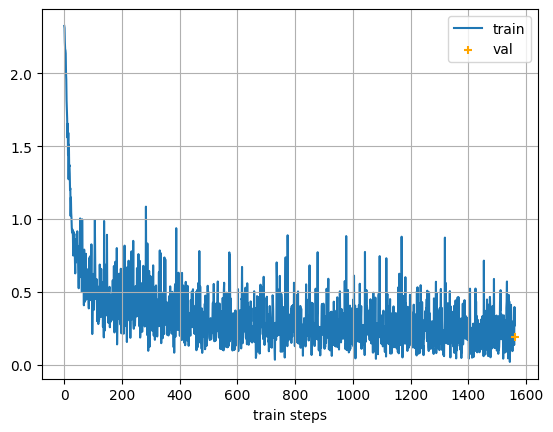

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 2958.86it/s]


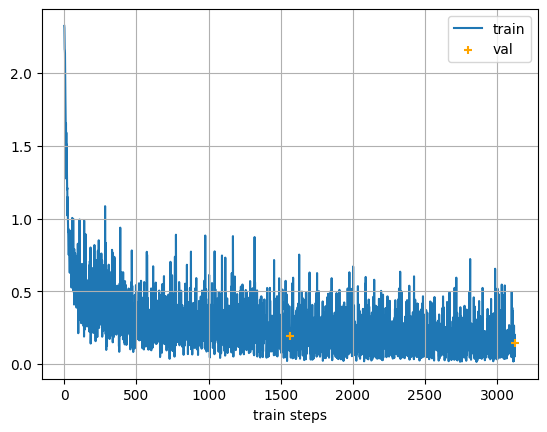

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 2776.39it/s]


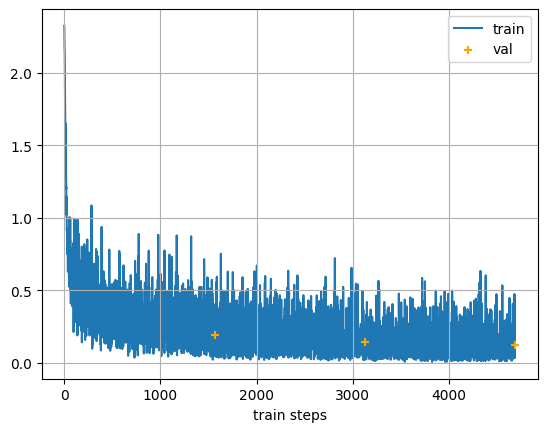

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 2730.59it/s]


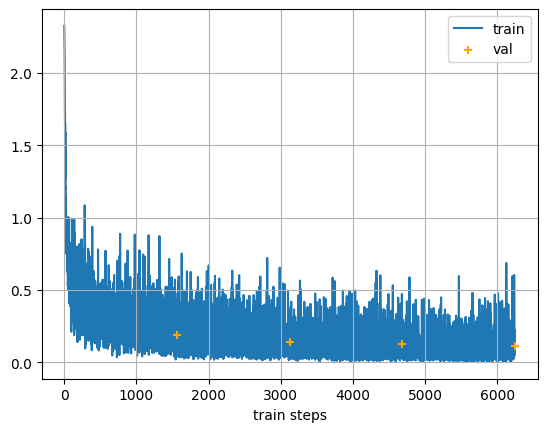

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 2679.03it/s]


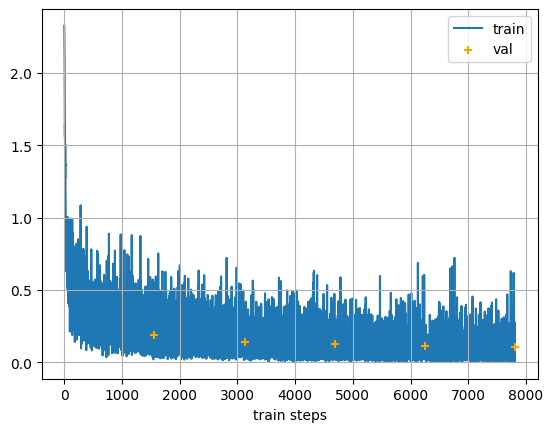

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 2943.64it/s]


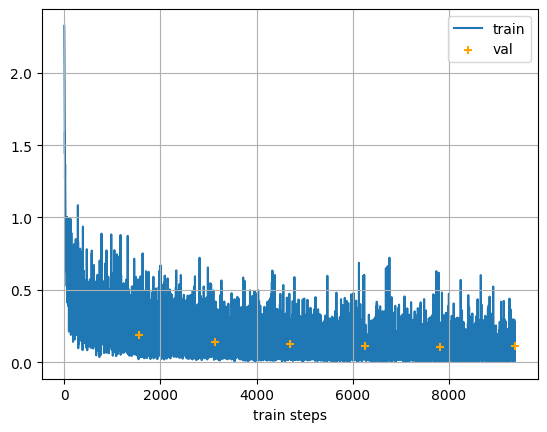

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 3650.66it/s]


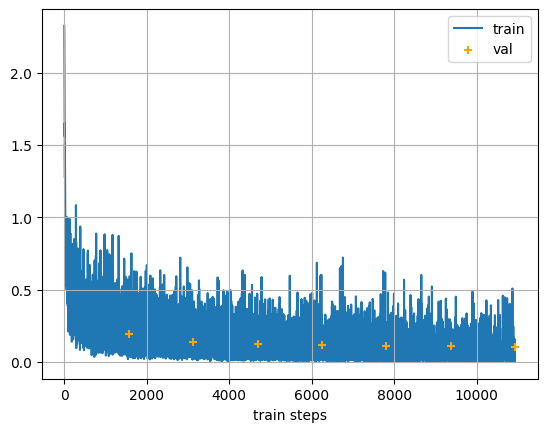

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 2911.48it/s]


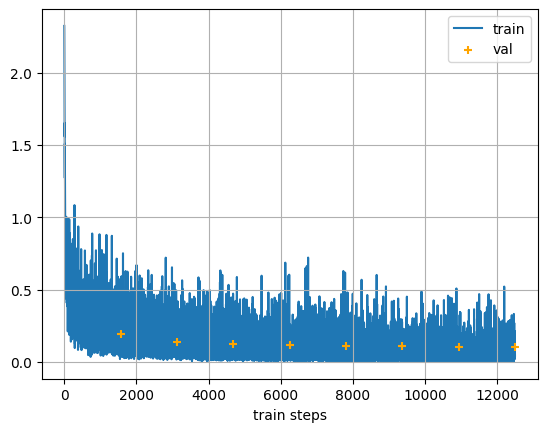

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 2732.71it/s]


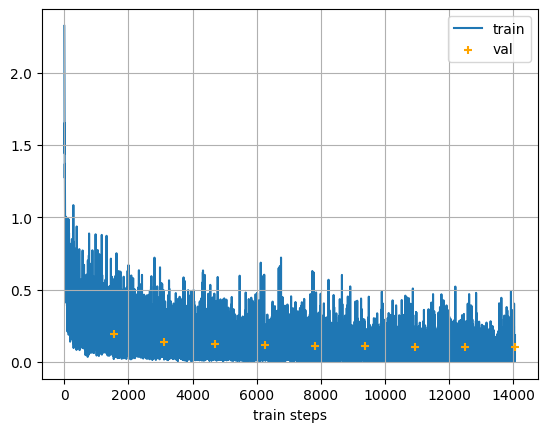

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 2709.77it/s]


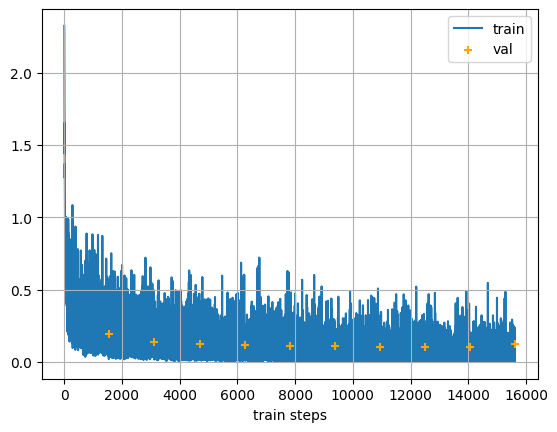

In [195]:
train_log = []
val_log = []

model = Net()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
batchsize = 32

for epoch in range(10):
    train_loss = train(model, opt, batchsize=batchsize)
    train_log.extend(train_loss)
    val_loss = np.mean(test(model))
    val_log.append((len(X_train) / batchsize * (epoch + 1), np.mean(val_loss)))
    
    
        
# TODO: plot train_loss vs train_steps line and  val_loss vs trained_steps points
    plot_history(train_log, val_log)  

# hint: train_log and val_log may contain data with different shapes

### Metrics

Logloss is difficult to interpret.
For tracking training and comparing models, it is more convenient to observe interpretable metrics, such as accuracy

Modify the train / test function code so that in addition to the error, the batch accuracy is calculated:

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 2806.99it/s]


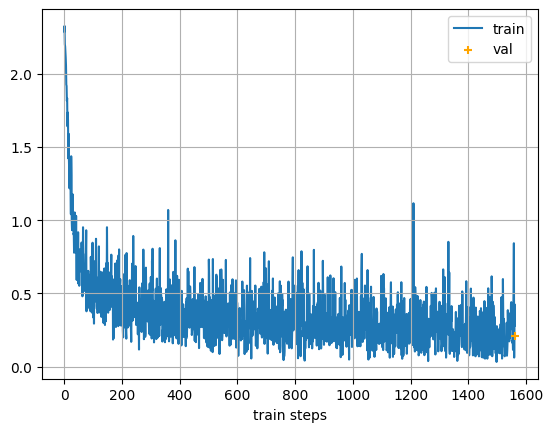

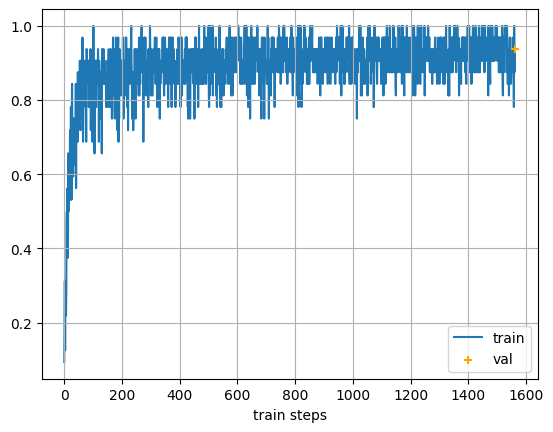

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 3278.20it/s]


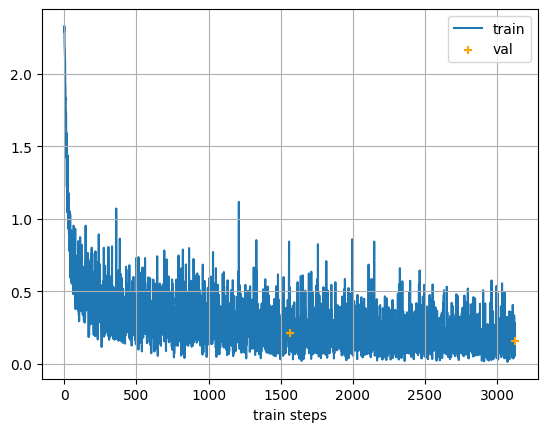

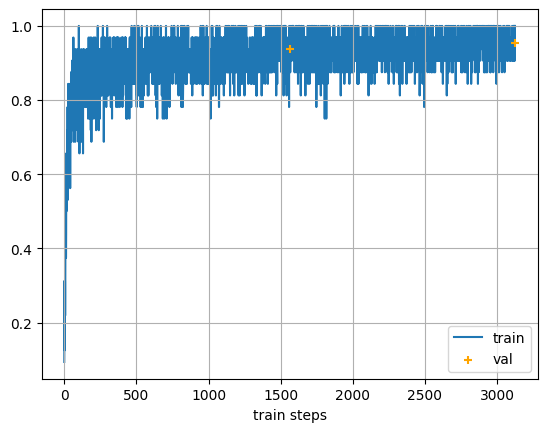

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 3194.40it/s]


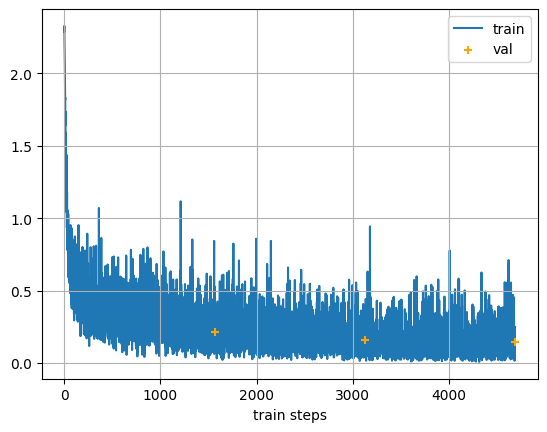

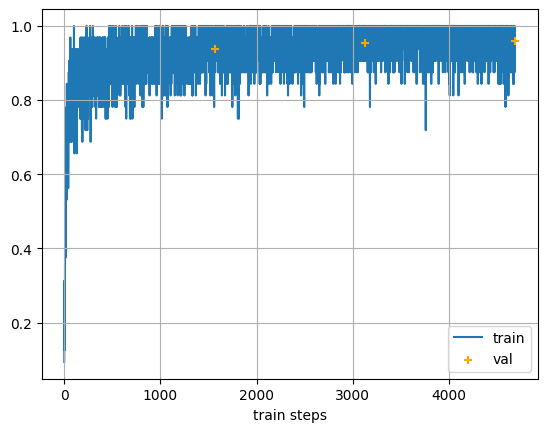

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 2236.32it/s]


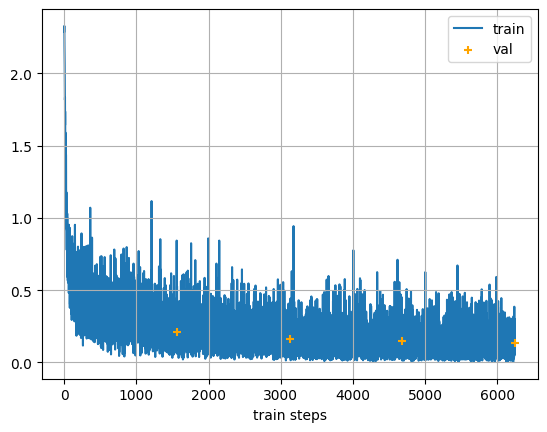

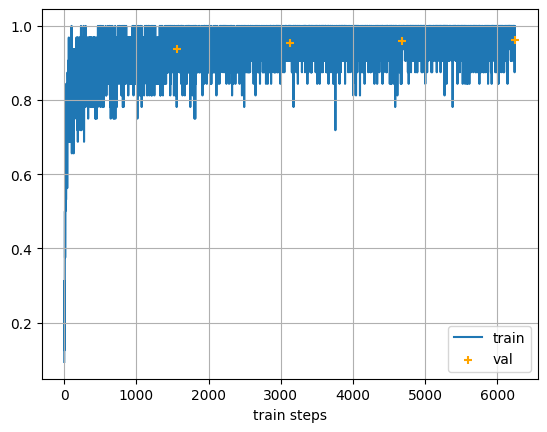

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 3323.36it/s]


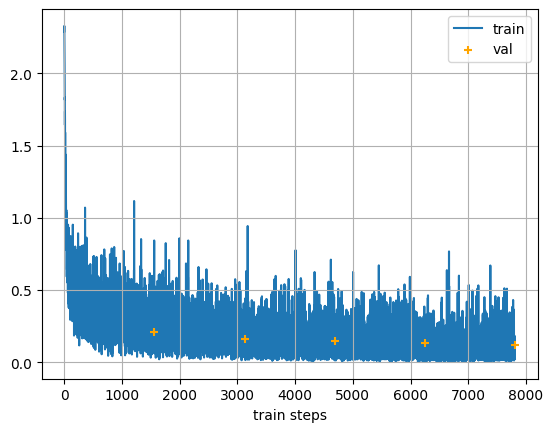

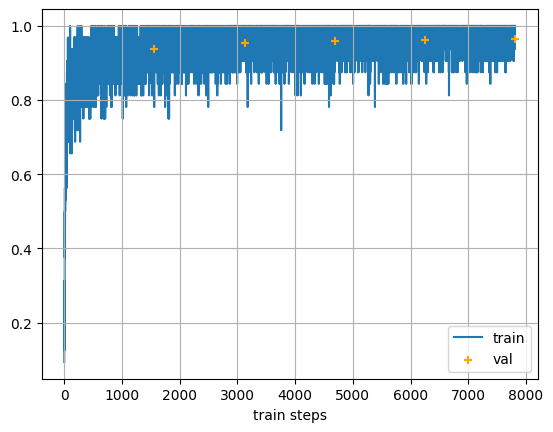

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 3850.27it/s]


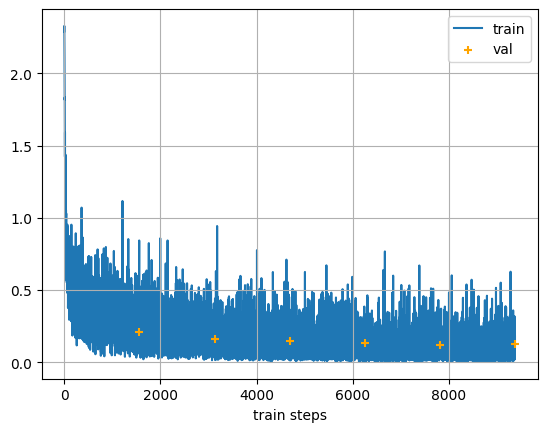

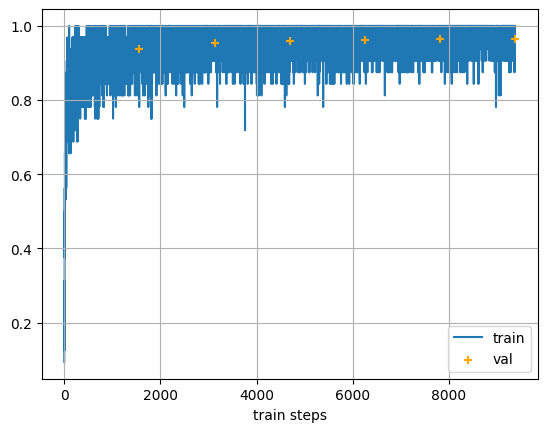

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 3652.56it/s]


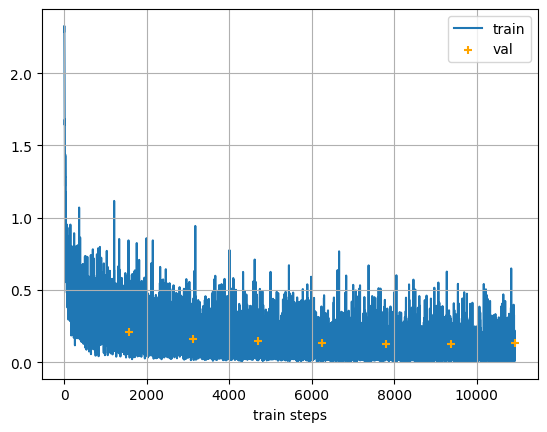

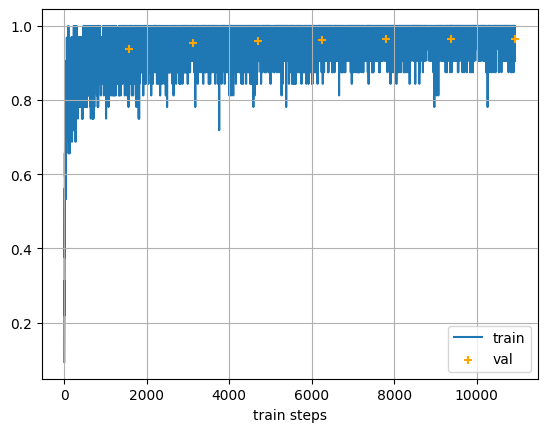

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 3565.20it/s]


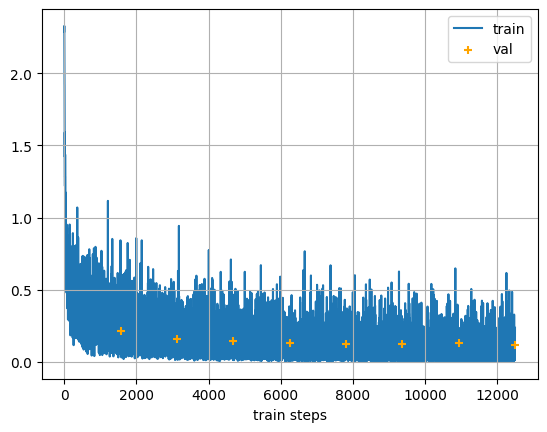

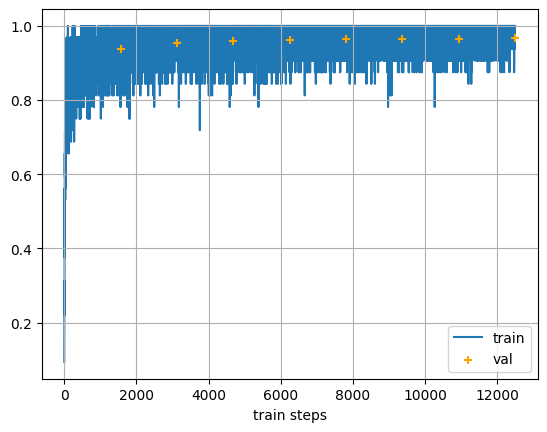

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 3569.91it/s]


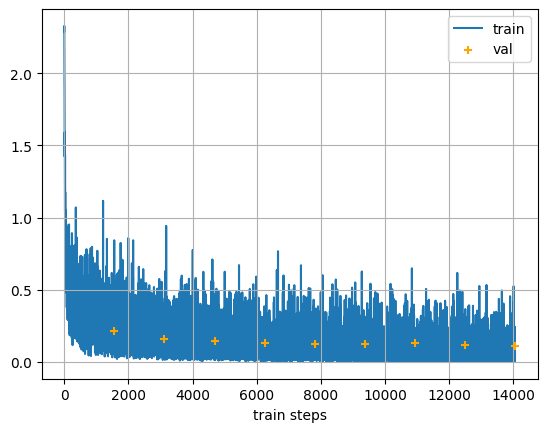

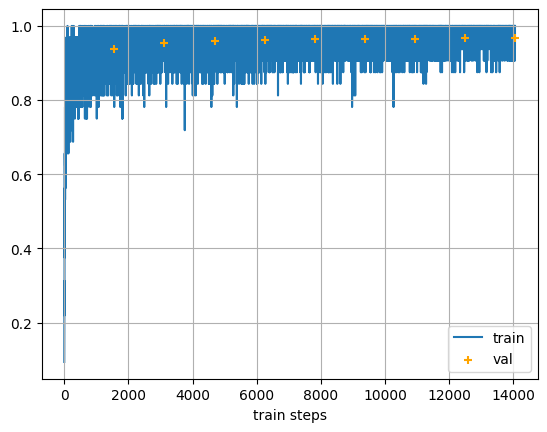

100%|███████████████████████████████████████| 312/312 [00:00<00:00, 3331.06it/s]


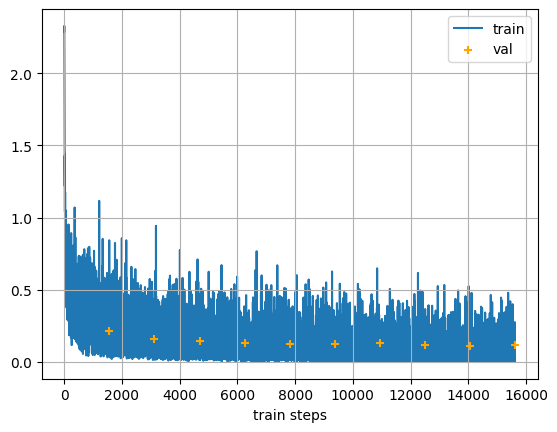

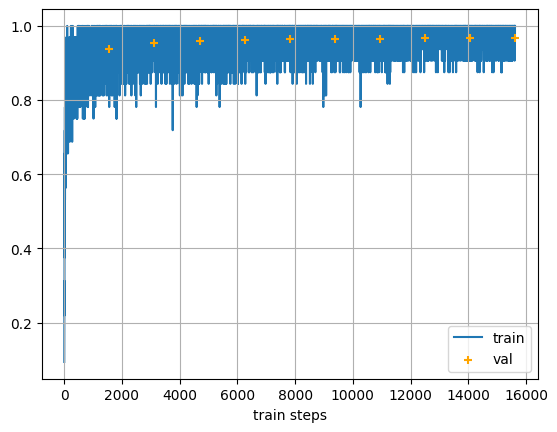

In [192]:
# TODO: add accuracy calculations
def train(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    
    # TODO <your code>
    
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        
        #calculating accuracy here
        pred = torch.max(output, 1)[1].data.numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.data
        loss_log.append(loss)
    
    
    return loss_log, acc_log


# TODO: add precision calculaitons:
def test(model):
    loss_log, acc_log = [], []
    
    # TODO <your code>
    model.eval()
    for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=32, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        output = model(data)
        loss = F.nll_loss(output, target)
        
        #calculating accuracy here
        pred = torch.max(output, 1)[1].data.numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = loss.data
        loss_log.append(loss)
    
    return loss_log, acc_log


train_log, train_acc_log = [], []
val_log, val_acc_log = [], []

model = Net()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
batchsize = 32


    

for epoch in range(10):
    # train
    # TODO <your code>
    train_loss, train_acc = train(model, opt, batchsize=batchsize)
    # test
    # TODO <your code>
    val_loss, val_acc = test(model)

    # store metrics
    # TODO <your code>
    train_log.extend(train_loss)
    train_acc_log.extend(train_acc)
    
    steps = len(X_train) / batchsize
    val_log.append((steps * (epoch + 1), np.mean(val_loss)))
    val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))
    
    # plot all metrics (loss and acc for train/val)
    # TODO <your code>
    plot_history(train_log, val_log)    
    plot_history(train_acc_log, val_acc_log, title='accuracy')   
